In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn as skl
from sklearn import ensemble, preprocessing
from matplotlib import pyplot
import seaborn as sbn

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/unweariedsphere/ce888_2020/master/lab4/bank-additional-full.csv', delimiter=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


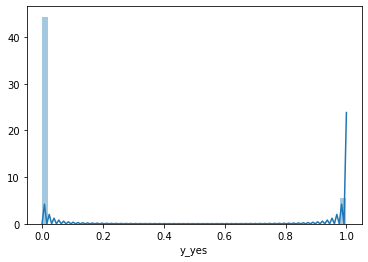

In [4]:
df_dummies = pd.get_dummies(df)

#drop duration column and all rows where y=no
try:
    df_dummies = df_dummies.drop(columns='duration') #throws exception if no "duration" column exists
    df_dummies = df_dummies.drop(columns='y_no') #throws exception if no "y_no" column exists
except:
    print() #python doesn't allow empty catch blocks so an empty print call is placed here

#textvars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
#df[textvars] = df[textvars].apply(preprocessing.LabelEncoder().fit_transform)


x = df_dummies.copy()
del x['y_yes'] #drop the y_yes column from the training data
y = df_dummies['y_yes']

sbn.distplot(y, hist=True)

In [5]:
etc = skl.ensemble.ExtraTreesClassifier(n_estimators=100)
etc.fit(x,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [0]:
y_pred = etc.predict(x)

In [0]:
scores = skl.model_selection.cross_val_score(etc, x, y, cv=10, scoring='neg_mean_squared_error')

In [8]:
np.set_printoptions(3)

dummy_alg = skl.dummy.DummyRegressor(strategy='mean') 
dummy_alg_scores = skl.model_selection.cross_val_score(dummy_alg, x, y, cv=10, scoring='neg_mean_squared_error')
print("validation fold mean squared errors:")
results = scores * -1 #convert negative MSEs to positve ones
print(results)
print("Mean Score = " + str(np.mean(results)) + "; Std. Dev. = " + str(np.std(results)))
print("dummy alg cross validation mean squared errors:")
print(dummy_alg_scores * -1)
dummy_results = dummy_alg_scores * -1
print("Mean Score = " + str(np.mean(dummy_results)) + "; Std. Dev. = " + str(np.std(dummy_results)))

validation fold mean squared errors:
[0.113 0.139 0.681 0.234 0.259 0.579 0.663 0.838 0.539 0.738]
Mean Score = 0.47820532457118076; Std. Dev. = 0.25349920294855866
dummy alg cross validation mean squared errors:
[0.036 0.041 0.047 0.065 0.062 0.056 0.092 0.105 0.135 0.397]
Mean Score = 0.10345690219481214; Std. Dev. = 0.10218101469110678


In [9]:
#get the algorithm's assigned importance of each feature
imps = etc.feature_importances_
#create array containing the standard deviations for each feature importance measure
imp_stds = np.std([tree.feature_importances_ for tree in etc], axis=0)
#get the index of each feature
imp_inds = np.argsort(imps)[::-1]

feature_list = list(df_dummies)
print("Feature rankings:")
for i in range(df_dummies.shape[1] - 1):
    print("Rank: " + str(i) + " \tImportance Score: " + str(imps[imp_inds[i]]) + "\tStd.Dev.: " + str(imp_stds[i]) + "\tFeature: " + feature_list[i])

Feature rankings:
Rank: 0 	Importance Score: 0.1554508916531402	Std.Dev.: 0.004822647767338512	Feature: age
Rank: 1 	Importance Score: 0.10522892683551258	Std.Dev.: 0.00363219024283186	Feature: campaign
Rank: 2 	Importance Score: 0.10079472505549297	Std.Dev.: 0.03979636968844363	Feature: pdays
Rank: 3 	Importance Score: 0.040531261777542946	Std.Dev.: 0.006130517349087508	Feature: previous
Rank: 4 	Importance Score: 0.03422132804108247	Std.Dev.: 0.02696120025153588	Feature: emp.var.rate
Rank: 5 	Importance Score: 0.03076650359417764	Std.Dev.: 0.01373782115467754	Feature: cons.price.idx
Rank: 6 	Importance Score: 0.024863443797180772	Std.Dev.: 0.016588488081779804	Feature: cons.conf.idx
Rank: 7 	Importance Score: 0.020782603646516785	Std.Dev.: 0.0353393338135593	Feature: euribor3m
Rank: 8 	Importance Score: 0.02046980346015563	Std.Dev.: 0.027802978526284123	Feature: nr.employed
Rank: 9 	Importance Score: 0.018373914782313476	Std.Dev.: 0.0028561297489336016	Feature: job_admin.
Rank: 10 	I

<BarContainer object of 62 artists>

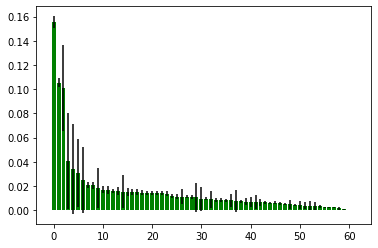

In [10]:
import matplotlib.pyplot as plt
importance_figure = plt.figure()
plt.bar(range(df_dummies.shape[1] - 1), imps[imp_inds], color="g", yerr=imp_stds[imp_inds], align="center")

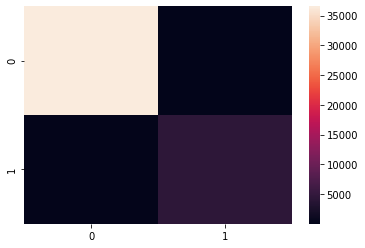

In [11]:
import seaborn
cnf_matrix = skl.metrics.confusion_matrix(y, y_pred) #get confusion matrix from tree classifier
seaborn.heatmap(cnf_matrix) #print confusion matrix as a seaborn heatmap